## Train model to detect ships in satellite images

In [90]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
import sys

# autoreload changes from local files
%load_ext autoreload
%autoreload 2

# dataframe display settings
pl.Config.set_fmt_str_lengths(100)
pl.Config.set_tbl_rows(100)
pl.Config.set_tbl_cols(50)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


polars.config.Config

In [91]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as ds

from sklearn.model_selection import train_test_split

In [92]:
from airbus_ship_detection import augmentation
from airbus_ship_detection import configs
from airbus_ship_detection import datasets
from airbus_ship_detection import losses
from airbus_ship_detection import metrics
from airbus_ship_detection import models
from airbus_ship_detection import processing
from airbus_ship_detection import trainer
from airbus_ship_detection import visuals

In [112]:
# load with polars
df_segments = pl.read_csv(configs.DIR_DATA / "train_ship_segmentations_v2.csv")

# add number of ships
df_segments = processing.process_labels(df_segments, 
                                        ratio_img_wo_ships=configs.RATIO_IMG_WO_SHIPS,
                                        random_state=configs.RANDOM_STATE)
df_segments.head()

Before undersampling, dataset size: 231723
After undersampling, dataset size: 89223


ImageId,EncodedPixels,n_ships,has_ship
str,str,u32,bool
"""000155de5.jpg""","""264661 17 265429 33 266197 33 266965 33 267733 33 268501 33 269269 33 270037 33 270805 33 271573 33 …",1,true
"""000194a2d.jpg""","""360486 1 361252 4 362019 5 362785 8 363552 10 364321 10 365090 9 365858 10 366627 10 367396 9 368165…",5,true
"""000194a2d.jpg""","""51834 9 52602 9 53370 9 54138 9 54906 9 55674 7 56442 7 57210 7 57978 7 58746 7 59514 7 60282 7 6105…",5,true
"""000194a2d.jpg""","""198320 10 199088 10 199856 10 200624 10 201392 10 202160 10 202928 10 203696 10 204464 10 205232 10 …",5,true
"""000194a2d.jpg""","""55683 1 56451 1 57219 1 57987 1 58755 1 59523 1 60291 1""",5,true


In [113]:
df_train, df_val = processing.split_train_val(df_segments, random_state=configs.RANDOM_STATE, train_size=configs.TRAIN_SIZE, test_size=configs.TEST_SIZE, verbose=True)

Number of unique images in train: 1000, val: 200


In [114]:
df_train['has_ship'].value_counts()

has_ship,count
bool,u32
false,150
true,1642


In [115]:
df_train['n_ships'].value_counts().sort('n_ships')

n_ships,count
u32,u32
0,150
1,541
2,306
3,177
4,128
5,95
6,78
7,56
8,48


In [116]:
df_val['n_ships'].value_counts().sort('n_ships')

n_ships,count
u32,u32
0,30
1,108
2,62
3,36
4,24
5,20
6,18
7,14
8,8


In [117]:
configs.RUN_ID

1000

Train samples : 1000 | Validation samples : 200
Restored model, epoch 2, step 97
Using device mps


Epoch 2, lr 0.0001:  99%|█████████▉| 1000/1008 [00:22<00:00, 44.41it/s, loss=0.01406]


Validation
Valid loss: 0.01201, IoU: 0.44121, Jaccard: 0.60154, Dice: 0.65717


Epoch 3, lr 0.0001:  99%|█████████▉| 1000/1008 [00:22<00:00, 44.43it/s, loss=0.01235]


Validation
Valid loss: 0.01044, IoU: 0.45897, Jaccard: 0.62716, Dice: 0.67750


Epoch 4, lr 0.0001:  99%|█████████▉| 1000/1008 [00:22<00:00, 44.12it/s, loss=0.01252]


Validation
Valid loss: 0.00964, IoU: 0.46278, Jaccard: 0.62189, Dice: 0.67861


Epoch 5, lr 0.0001:  99%|█████████▉| 1000/1008 [00:22<00:00, 44.64it/s, loss=0.01166]


Validation
Valid loss: 0.00890, IoU: 0.41855, Jaccard: 0.61918, Dice: 0.66105


Epoch 6, lr 0.0001:  99%|█████████▉| 1000/1008 [00:22<00:00, 43.81it/s, loss=0.01176]


Validation
Valid loss: 0.00833, IoU: 0.48265, Jaccard: 0.61522, Dice: 0.66707


Epoch 7, lr 0.0001:  99%|█████████▉| 1000/1008 [00:22<00:00, 44.79it/s, loss=0.00866]


Validation
Valid loss: 0.00658, IoU: 0.43118, Jaccard: 0.62552, Dice: 0.66911


Epoch 8, lr 0.0001:  99%|█████████▉| 1000/1008 [00:21<00:00, 45.54it/s, loss=0.00803]


Validation
Valid loss: 0.00601, IoU: 0.51067, Jaccard: 0.63203, Dice: 0.68094


Epoch 9, lr 0.0001:  99%|█████████▉| 1000/1008 [00:21<00:00, 45.64it/s, loss=0.00660]


Validation
Valid loss: 0.00578, IoU: 0.49303, Jaccard: 0.62830, Dice: 0.67986


Epoch 10, lr 0.0001:  99%|█████████▉| 1000/1008 [00:21<00:00, 45.64it/s, loss=0.00655]


Validation
Valid loss: 0.00581, IoU: 0.49819, Jaccard: 0.62746, Dice: 0.67621


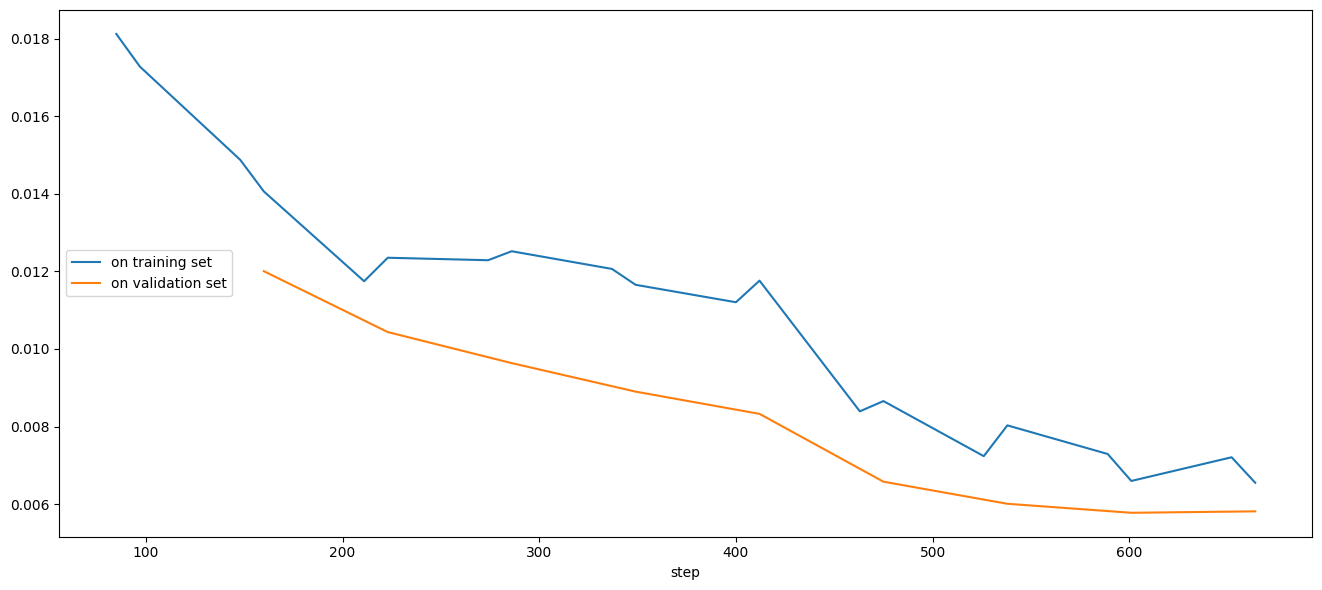

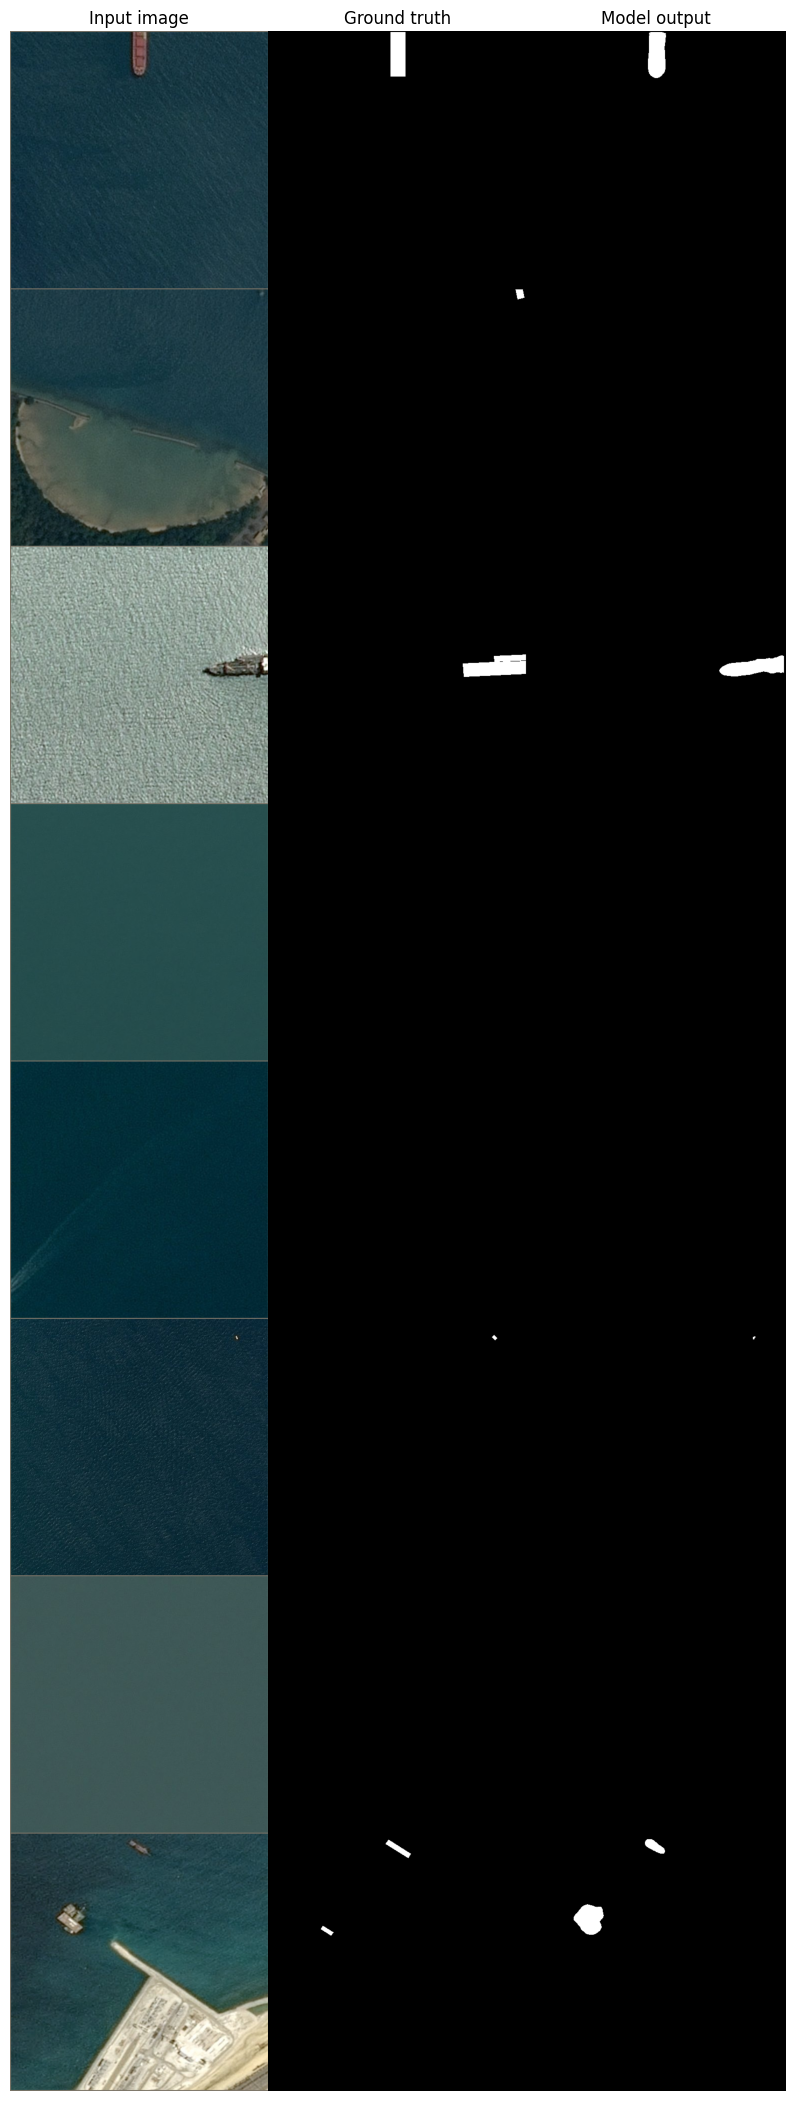

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from airbus_ship_detection import configs
from airbus_ship_detection import models
from airbus_ship_detection import processing
from airbus_ship_detection.datasets import AirbusDataset
from airbus_ship_detection.losses import *
from airbus_ship_detection.models import *
from airbus_ship_detection.metrics import *
from airbus_ship_detection.trainer import train
from airbus_ship_detection.augmentation import CenterCrop, DualCompose, HorizontalFlip, RandomCrop, VerticalFlip
from airbus_ship_detection.datasets import AirbusDataset

# data augmentation
train_transform = DualCompose([HorizontalFlip(), VerticalFlip(), RandomCrop((256,256,3))])
val_transform = DualCompose([CenterCrop((512,512,3))])

# Initialize dataset
train_dataset = AirbusDataset(df_train, transform=train_transform, mode='train')
val_dataset = AirbusDataset(df_val, transform=val_transform, mode='validation')

print('Train samples : %d | Validation samples : %d' % (len(train_dataset), len(val_dataset)))

# Get loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=configs.BATCH_SZ_TRAIN, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=configs.BATCH_SZ_VALID, shuffle=True, num_workers=0)

if configs.SHOW_IMG_LOADER == True:
    # Display some images from loader
    images, mask = next(iter(train_loader))
    processing.imshow_mask(torchvision.utils.make_grid(images, nrow=1), torchvision.utils.make_grid(mask, nrow=1))
    plt.show()
    
# Train
model_name = configs.MODEL
model = models.MODELS[model_name]
    
if configs.LOSS == 'BCEWithDigits':
    criterion = nn.BCEWithLogitsLoss()
elif configs.LOSS == 'FocalLossWithDigits':
    criterion = MixedLoss(10, 2)
elif configs.LOSS == 'BCEDiceWithLogitsLoss':
    criterion = BCEDiceWithLogitsLoss()
elif configs.LOSS == 'BCEJaccardWithLogitsLoss':
    criterion = BCEJaccardWithLogitsLoss()
else:
    raise NameError("loss not supported")

train(init_optimizer=lambda lr: optim.Adam(model.parameters(), lr=lr),
        lr = configs.LR,
        n_epochs = configs.N_EPOCHS,
        model = model,
        model_name = model_name,
        criterion=criterion,
        train_loader=train_loader,
        valid_loader=val_loader,
        train_batch_sz= configs.BATCH_SZ_TRAIN,
        valid_batch_sz= configs.BATCH_SZ_VALID,
        fold=configs.RUN_ID,
        )


# Plot losses
log_path = configs.DIR_LOGS / f"{configs.MODEL}_{configs.RUN_ID}.log"
logs = pd.read_json(log_path, lines=True)

plt.figure(figsize=(26,6))
plt.subplot(1, 2, 1)
plt.plot(logs.step[logs.loss.notnull()],
            logs.loss[logs.loss.notnull()],
            label="on training set")

plt.plot(logs.step[logs.valid_loss.notnull()],
            logs.valid_loss[logs.valid_loss.notnull()],
            label = "on validation set")
         
plt.xlabel('step')
plt.legend(loc='center left')
plt.tight_layout()
plt.show()


# Model inference
model_path =configs.DIR_MODELS / f"{model_name}_{configs.RUN_ID}.pt"
state = torch.load(str(model_path))
state = {key.replace('module.', ''): value for key, value in state['model'].items()}
model.load_state_dict(state)

device = trainer.get_torch_device()
model = model.to(device)
model.eval()

val_dataset = AirbusDataset(df_val, transform=val_transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

# Display some images from loader
images, gt = next(iter(val_loader))
gt = gt.data.cpu()
images = images.to(device)
out = model.forward(images)
out = ((out > 0).float()) * 255
images = images.data.cpu()
out = out.data.cpu()
processing.imshow_gt_out(torchvision.utils.make_grid(images, nrow=1),torchvision.utils.make_grid(gt, nrow=1), torchvision.utils.make_grid(out, nrow=1))
plt.show()

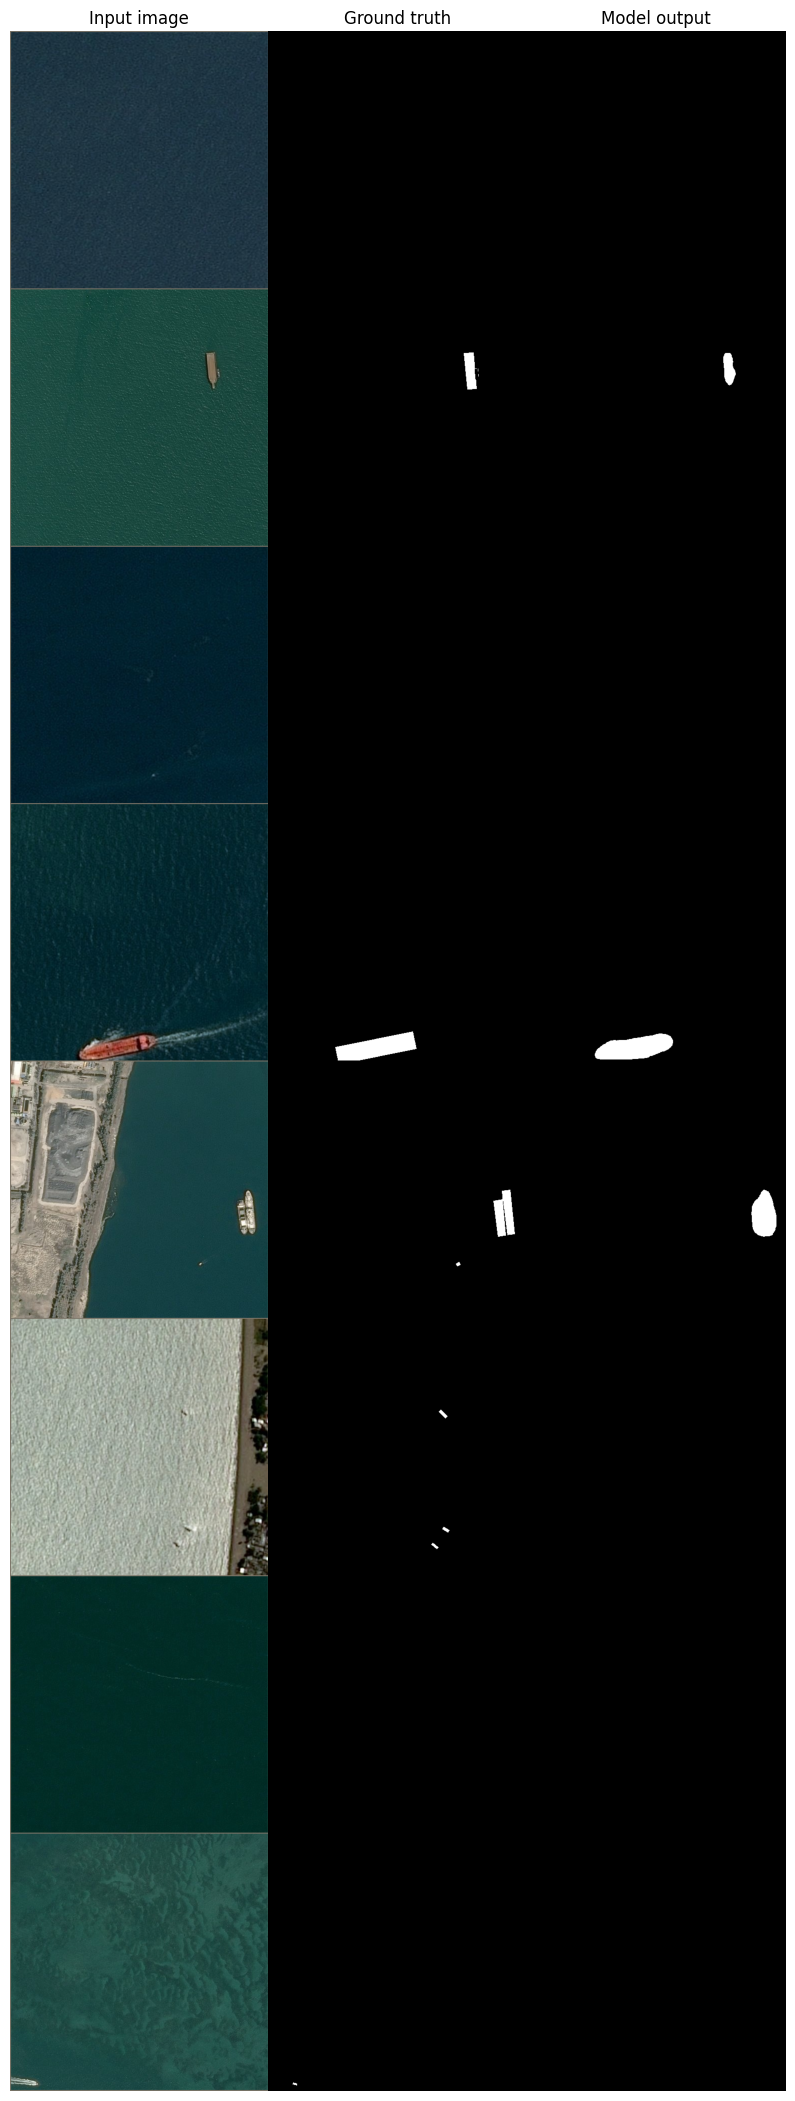

In [110]:
# Display some images from loader
images, gt = next(iter(val_loader))
gt = gt.data.cpu()
images = images.to(device)
out = model.forward(images)
out = ((out > 0).float()) * 255
images = images.data.cpu()
out = out.data.cpu()
processing.imshow_gt_out(torchvision.utils.make_grid(images, nrow=1),torchvision.utils.make_grid(gt, nrow=1), torchvision.utils.make_grid(out, nrow=1))
plt.show()

In [48]:
model = models.get_model('UNET_RESNET34ImgNet')
model

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [108]:
model.state_dict()

OrderedDict([('encoder.conv1.weight',
              tensor([[[[ 3.1166e-03, -8.2892e-03,  6.6712e-03,  ...,  4.8060e-02,
                          2.9101e-02,  2.4687e-02],
                        [ 3.9177e-02,  3.0430e-02,  3.1640e-02,  ...,  3.3280e-02,
                          2.9894e-02,  4.2123e-02],
                        [ 1.8266e-03, -3.3030e-02, -6.1560e-02,  ..., -9.7675e-02,
                         -1.1606e-01, -1.2143e-01],
                        ...,
                        [-1.4943e-02, -2.5665e-02, -9.8426e-03,  ...,  1.6129e-02,
                          1.6278e-03,  1.5735e-02],
                        [ 2.0937e-03,  3.5673e-03,  3.5948e-02,  ...,  1.0272e-01,
                          7.3288e-02,  5.8615e-02],
                        [ 1.5542e-02,  8.2662e-03,  3.1531e-02,  ...,  9.6997e-02,
                          8.3933e-02,  9.7004e-02]],
              
                       [[-1.0549e-02, -1.0061e-02,  1.3246e-02,  ...,  3.3427e-02,
                        